In [10]:
#lung segmentation and measuring lung volume
!pip install pydicom
import math
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2 as cv
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread
init_notebook_mode(connected=True) 
#link to the ct images folder
data_path = '/content/drive/MyDrive/ct phổi/Dicom_DAO THI HOAN CT_183764126_858/1.3.12.2.1107.5.1.4.83610.30000020120513590324800165925/'
#export result to other folder
output_path = working_path ='/content/drive/My Drive/ct result/'
#open dicom files
g = glob(data_path+'/*.dcm')
#loop over the image files and store everything into a list
def load_scan(path):
  #os.listdir(path) = name of all files in path
  #dicom_read_file() get the dataset of ct image in string type
  slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
  #order the list by the increasement of instancenumber
  #[(0020,0013),(0020,0011),(0020,0015)]->[(0020,0011),(0020,0013),(0020,0015)]
  slices.sort(key = lambda x: int(x.InstanceNumber))
  #if 'try' fail or error, 'except' code will be operated
  try:
    #Position coordinate [x,y,z] , ImagePositionPatient[2] get the z coordinate
    #abs absolute value
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
  for s in slices:
    s.SliceThickness = slice_thickness       
  return slices

#convert raw values of voxel in the images to HU
def get_pixels_hu(scans):
  #s.pixel_array get ct image's pixel data in matrix 
  #np.stack join many array(matrix) with the same dimension into new sequence
  image = np.stack([s.pixel_array for s in scans])
  # should be possible as values should always be low enough (<32k)
  #convert all dataframe columns into dtype int16
  image = image.astype(np.int16) 
  # Set outside-of-scan pixels (HU = -2000) to 0
  # The intercept(threshold) is usually -1024, so air is approximately 0
  image[image == -2000] = 0    
  # Convert to Hounsfield units (HU=pixel_value*slope+intercept)
  intercept = scans[0].RescaleIntercept
  slope = scans[0].RescaleSlope   
  if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)        
  image += np.int16(intercept)   
  return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #map(function,iterable) -> return a list,tuple to inform function
    #get scan to be in form of float number
    spacing = [scan[0].SliceThickness,scan[0].PixelSpacing[0],scan[0].PixelSpacing[1]] 
    #change list to array
    spacing = np.array(spacing)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    #round after comma ','
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    #change the size of image with a factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]  
    #compute average value  
    mean = np.mean(img)
    #compute standard deviation
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, moving the underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean

    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air) -> cluster = 2
    #np.reshape(reshaped array, newshape (row,col))
    #np.prod() return number of elements in array
    #np.reshape(middle,[np.prod(middle.shape),1] change the array into [elementsx1] size
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    #cluster_centers_: array(n.o cluster, n.o features) Coordinates of cluster centers.
    #.flatten() return array to one dimension 
    #sorted() sort array from 1->n, alphabet a,b,c,d,...
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    #np.where(condition, true, else) if img<threshold, img =1, else = 0
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    # Different labels are displayed in different colors
    labels = measure.label(thresh_img) 
    #np.unique() sorted unique elements of array
    label_vals = np.unique(labels)
    #Measure properties of labeled image regions.
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
      #bbbox(bounding box):tuple (min_row, min_col, max_row, max_col)
        B = prop.bbox
        C = prop.area
        if B[0]>0 and B[1]>0 and C > 400 and B[2]<img.shape[0] and B[3]<img.shape[1]-10:
            #label: int the label in labeled input img 
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    selem = disk(5)
    final_mask = ndi.binary_fill_holes(mask)
    original_mask = img*thresh_img*mask
    original_mask = np.where(original_mask!=0,1,0)
    new_label = measure.label(original_mask)
    #mask = morphology.dilation(mask,np.ones(3,3])) # one last dilation
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Color Labels")
        ax[1, 0].imshow(labels)
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Good Labels")
        ax[1, 1].imshow(mask, cmap='gray')
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(final_mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(new_label, cmap='gray')
        ax[2, 1].axis('off')
        plt.show()
    return final_mask
    #return mask
def shallowest_lung(lung_mask,min_row,min_col,max_row,max_col):
  col_size = []
  dis = int((max_col-min_col)/10)
  for i in range(min_col+dis,max_col-dis):
    a = 0
    for j in range(min_row,max_row+1):
      if lung_mask[j][i] == 1:
        a+=1
    col_size.append(a)
  mincol_index = min_col + dis + col_size.index(min(col_size))
  for k in range(min_row,max_row+1):
    if lung_mask[k][mincol_index] == 1:
      break
  minrow_index = k
  return mincol_index, minrow_index      

#for connected mask only
def connected_region(img_connected, img_original):
  row = img_connected.shape[0]
  col = img_connected.shape[1]
  label_img = measure.label(img_connected)
  label_vals = np.unique(label_img)
  regions = measure.regionprops(label_img)
  for prop in regions:
    box = prop.bbox 
    lung_area = prop.area
  right_mask = np.ndarray([row,col],dtype=np.int8)
  right_mask[:] = 0
  good_labels = []
  col_min, row_min = shallowest_lung(img_connected,box[0],box[1],box[2],box[3])
  max_row = min([int(row_min+row/10),row])
  min_col = max([int(col_min-col/15),0])
  max_col = min([int(col_min+col/10),col])
  new_mask = np.zeros((row,col))
  for j in range(box[0],max_row):
    for k in range(min_col,max_col):
      if img_connected[j][k] == 1:
        new_mask[j][k] = 1
  new_img = img_original*new_mask
  number = []
  for i in new_img:
    for j in i:
      if j != 0:
        number.append(j)
  mean = np.mean(number)
  if mean == 0 or lung_area < 6000:
    if box[1] < col/2 and box[3]<col*8/10:
      good_labels.append(prop.label)
    for N in good_labels:
      right_mask = right_mask + np.where(label_img==N,1,0)
    right_mask = np.where(right_mask!=0,1,0)
    new_img = img_connected
  else:
    i = 0 
    new_label = np.ndarray([row,col],dtype=np.int8)
    while len(label_vals) == 2 and i <20: 
      new_img = np.where(new_img<mean,1,0) 
      diff = (new_img>0)^(new_mask>0)
      diff = np.where(diff==1,0,1)
      selem = disk(10)
      new_img = img_connected*diff
      new_img = ndi.binary_fill_holes(new_img)
      test_label = measure.label(new_img)
      label_vals = np.unique(test_label)
      if len(label_vals) != 2:
        region = measure.regionprops(test_label) 
        for prop in region:
          A = prop.area
          if A <100:
            new_label = np.where(test_label==prop.label,0,test_label)
        label_vals = np.unique(new_label)
      mean -= 10
      i+=1
    if len(label_vals) == 2:
      region = measure.regionprops(test_label) 
      for prop in region:
        B = prop.bbox
      mincol, minrow = shallowest_lung(new_img,B[0],B[1],B[2],B[3])
      for i in range(0,mincol):
        for k in range(0,row):
          if new_img[k][i] == 1:
            right_mask[k][i] = 1 
    else:
      region = measure.regionprops(test_label)
      for prop in region:
        B = prop.bbox
        if B[1]<col/2 and B[3]<col*8/10:
          good_labels.append(prop.label)
      for N in good_labels:
        right_mask = right_mask + np.where(test_label==N,1,0)
      right_mask = np.where(right_mask!=0,1,0)
  return right_mask, new_img


def divide_lung(img_original, display=False):
  img = make_lungmask(img_original)
  row = img.shape[0]
  col = img.shape[1] 
  label_img = measure.label(img)
  label_vals = np.unique(label_img)
  regions = measure.regionprops(label_img) 
  good_labels = []
  right_mask = np.ndarray([row,col],dtype=np.int8)
  right_mask[:] = 0
  left_mask = np.ndarray([row,col],dtype=np.int8)
  left_mask[:] = 0
  box = []
  label_part = []
  if len(label_vals) == 3:
    for prop in regions:
      box.append(prop.bbox)
      label_part.append(prop.label)
    if box[0][1] < box[1][1]:
      good_labels.append(label_part[0])
    else: 
      good_labels.append(label_part[1])
    for N in good_labels:
        right_mask = right_mask + np.where(label_img==N,1,0)
        right_mask = np.where(right_mask!=0,1,0)
    left_mask = img - right_mask

  if len(label_vals) > 3:
    for prop in regions:
      B = prop.bbox
      if B[0]>0 and B[1]>0 and B[2]<row and B[1]<col*4/10 and B[3]<col*7/10:
        #label: int the label in labeled input img 
        good_labels.append(prop.label)
      for N in good_labels:
        right_mask = right_mask + np.where(label_img==N,1,0)
        right_mask = np.where(right_mask!=0,1,0)
      left_mask = img - right_mask
      
  if len(label_vals) == 2:
    right_mask, img = connected_region(img,img_original)
    left_mask = img - right_mask
  if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img_original, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Label")
        ax[0, 1].imshow(img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Distance")
        ax[1, 0].imshow(label_img)
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Label")
        ax[1, 1].imshow(img, cmap='gray')
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Right mask")
        ax[2, 0].imshow(right_mask,cmap ='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Left mask")
        ax[2, 1].imshow(left_mask, cmap='gray')
        ax[2, 1].axis('off')        
        plt.show()
  return img,right_mask,left_mask

def measure_lung(img, px = 0):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]): 
      if img[i][j] == 1:
        px+=1
  return px

def sample_stack(stack, rows=10, cols=10, start_with=0, show_every=2):
    #get image size 12x12 and set the coordinate
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every        
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()



In [11]:
id=1
patient = load_scan(data_path)
print("slice thickness: %f" %patient[0].SliceThickness)

print("pixel spacing (row,col): (%f, %f)" %(patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))
imgs = get_pixels_hu(patient)
#save an array to a numpy file (.npy) format
np.save(output_path + "fullimages_%d.npy" %(id), imgs)
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64)
# each slice is resampled in 1x1x1 mm pixels and slices.
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
new_size = imgs_after_resamp.shape
print('image orginal:',imgs_to_process.shape)
print('image after resamp:',imgs_after_resamp.shape)
print('voxel value:',spacing)

mask_stack = np.zeros((imgs_after_resamp.shape[0],imgs_after_resamp.shape[1],imgs_after_resamp.shape[2]))
leftmask_stack = np.zeros((imgs_after_resamp.shape[0],imgs_after_resamp.shape[1],imgs_after_resamp.shape[2]))
rightmask_stack = np.zeros((imgs_after_resamp.shape[0],imgs_after_resamp.shape[1],imgs_after_resamp.shape[2]))
i = 0 
for img in imgs_after_resamp:
  mask_stack[i], rightmask_stack[i], leftmask_stack[i] = divide_lung(img)
  mask_stack[i] = np.where(mask_stack[i]!=0,1.0,0.0)
  rightmask_stack[i] = np.where(rightmask_stack[i]!=0,1.0,0.0)
  leftmask_stack[i] = np.where(leftmask_stack[i]!=0,1.0,0.0)
  i+=1
  print(i)
print(mask_stack.shape)
print(rightmask_stack.shape)
print(leftmask_stack.shape)



slice thickness: 1.000000
pixel spacing (row,col): (0.789062, 0.789062)
image orginal: (302, 512, 512)
image after resamp: (302, 404, 404)
voxel value: [1. 1. 1.]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
2

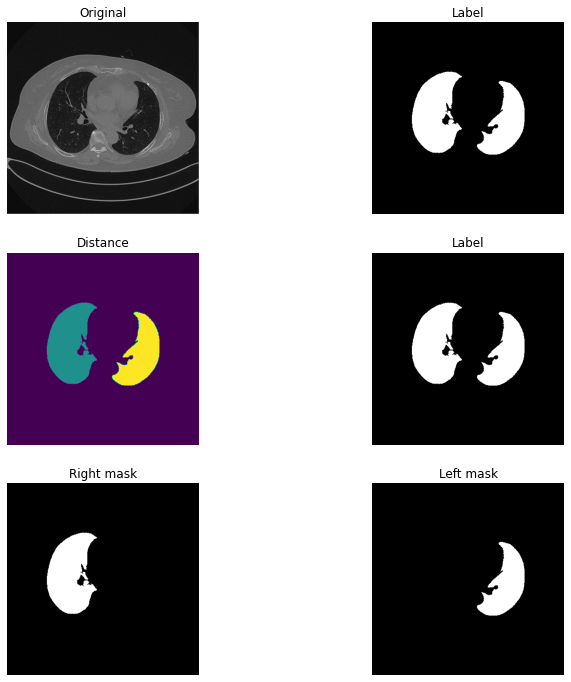

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

In [8]:
'''
img = make_lungmask(imgs_after_resamp[311], display=True)
k=0
for i in range(0,img.shape[0]):
  for j in range(0,img.shape[1]):
    if img[i][j] == 1:
      k+=1
print(k)
'''
divide_lung(imgs_after_resamp[156], display = True)
#mask_stack[i], rightmask_stack[i], leftmask_stack[i] = divide_lung(imgs_after_resamp[282], display = True)

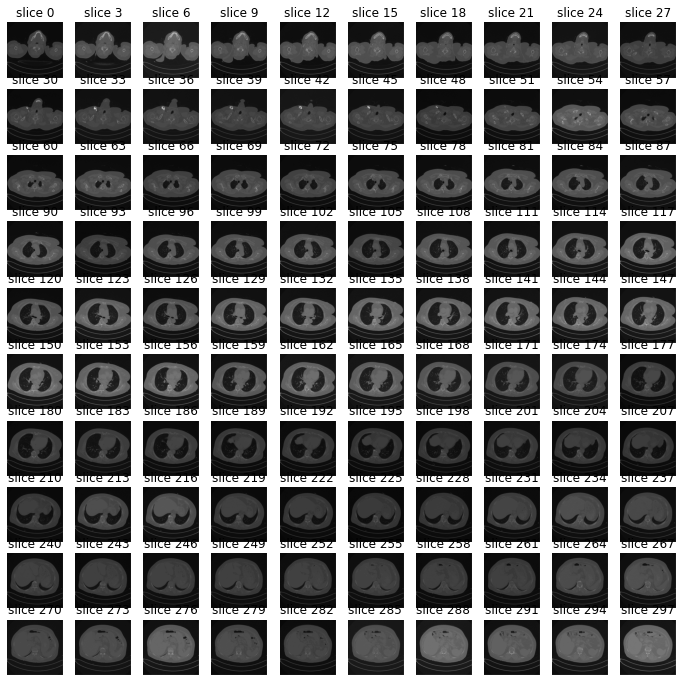

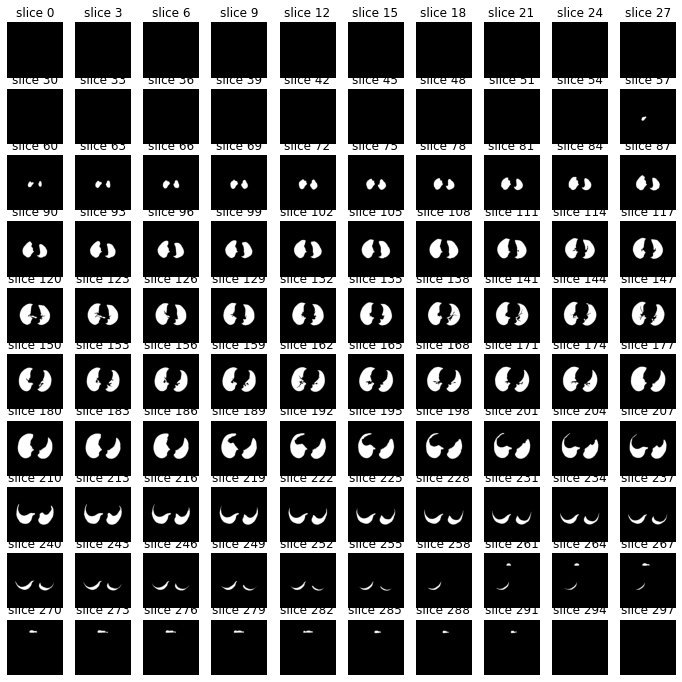

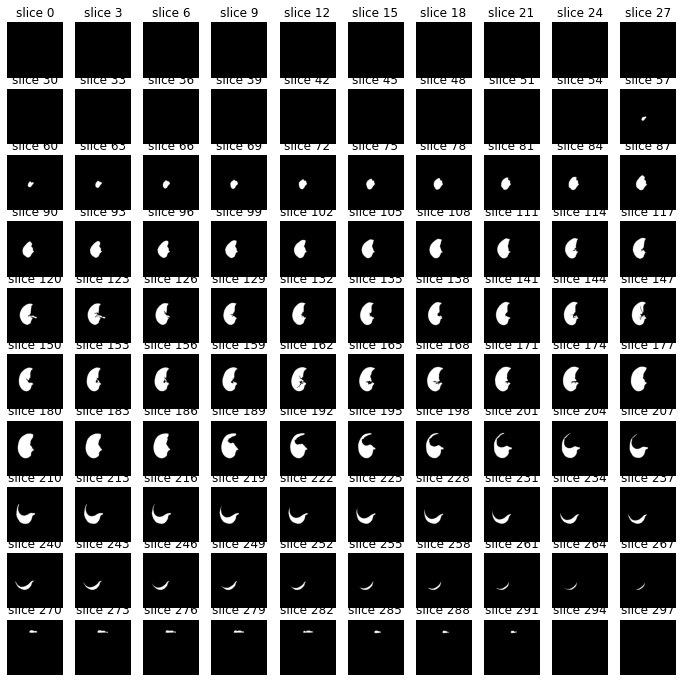

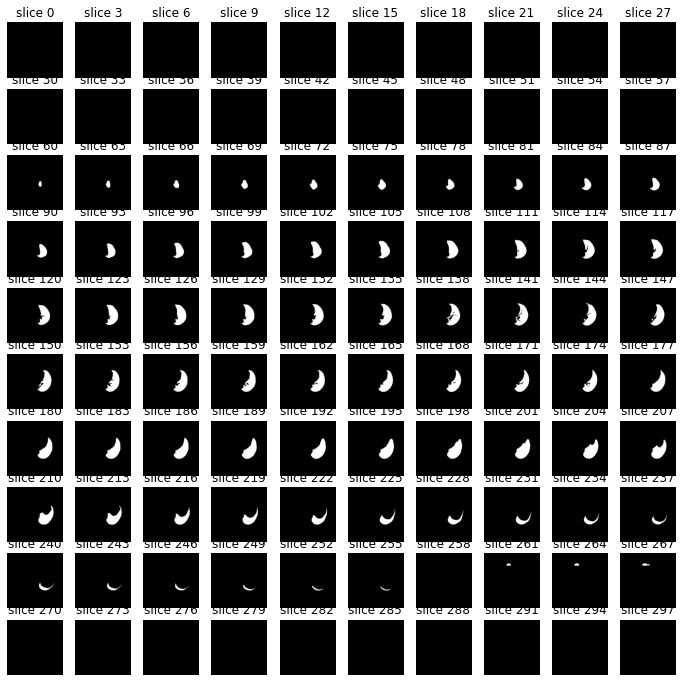

In [12]:
step = int(mask_stack.shape[0]/100)
sample_stack(imgs_after_resamp, start_with = 0, show_every = step)
sample_stack(mask_stack, start_with = 0, show_every = step)
sample_stack(rightmask_stack, start_with = 0, show_every = step)
sample_stack(leftmask_stack, start_with = 0, show_every = step)

<class 'numpy.ndarray'>
-832.8972437443527
[0 1]
3
-832.8972437443527
-1


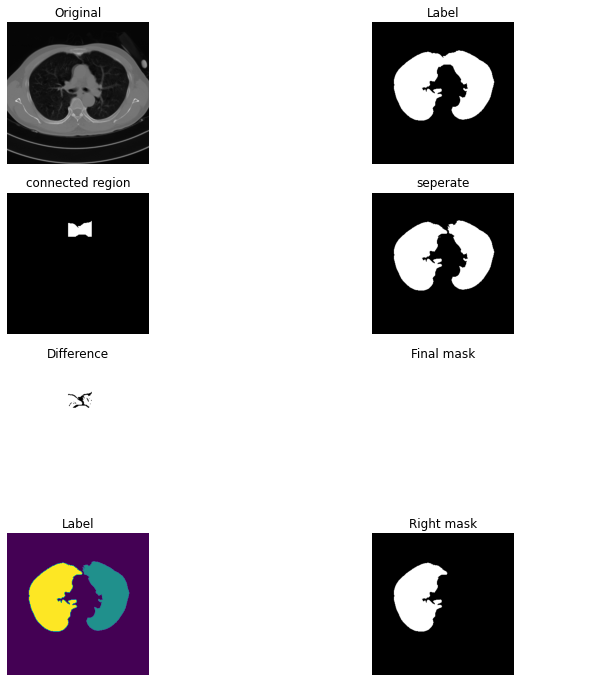

In [ ]:
i = 149
img_original = imgs_after_resamp[i]
img_connected = make_lungmask(img_original)
row = img_connected.shape[0]
col = img_connected.shape[1]
label_img = measure.label(img_connected)
label_vals = np.unique(label_img)
print(type(label_vals))
regions = measure.regionprops(label_img)
for prop in regions:
    box = prop.bbox 
    lung_area = prop.area
right_mask = np.ndarray([row,col],dtype=np.int8)
right_mask[:] = 0
good_labels = []
col_min, row_min = shallowest_lung(img_connected,box[0],box[1],box[2],box[3])
max_row = min([int(row_min+row/15),row])
min_col = max([int(col_min-col/15),0])
max_col = min([int(col_min+col/10),col])
new_mask = np.zeros((row,col))
for j in range(box[0],max_row):
  for k in range(min_col,max_col):
    if img_connected[j][k] == 1:
      new_mask[j][k] = 1
new_img = img_original*new_mask
number = []
for i in new_img:
  for j in i:
    if j != 0:
      number.append(j)
mean = np.mean(number)
print(mean)
print(label_vals)
if mean == 0 or lung_area < 1000:
  if box[1] < col/2 and box[3]<col*8/10:
    good_labels.append(prop.label)
  for N in good_labels:
    right_mask = right_mask + np.where(label_img==N,1,0)
  right_mask = np.where(right_mask!=0,1,0)
  new_img = img_connected
else:
  a = 0
  i = 0 
  while len(label_vals) == 2 and i <10: 
    mean += a
    new_img = np.where(new_img<mean,1,0) 
    diff = (new_img>0)^(new_mask>0)
    diff = np.where(diff==1,0,1)
    selem = disk(5)
    new_img = img_connected*diff
    new_img = ndi.binary_fill_holes(new_img)
    test_label = measure.label(new_img)
    label_vals = np.unique(test_label)
    region = measure.regionprops(test_label)
    if len(label_vals) != 2:
      for prop in region:
        A = prop.area
        if A < 100:
          test_label = np.where(test_label==prop.label,0,test_label)
    label_vals = np.unique(test_label)
    print(len(label_vals))
    a -= 1
    i+=1
    print(mean)
    print(a)
  
  for prop in region:
    B = prop.bbox
    if B[1]<col/2 and B[3]<col*7/10:
      good_labels.append(prop.label)
  for N in good_labels:
     right_mask = right_mask + np.where(test_label==2,1,0)
  right_mask = np.where(right_mask!=0,1,0)

'''
if len(label_vals) == 2:
  distance = ndimage.distance_transform_edt(img)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=img)
    markers = morphology.label(local_maxi)
    labels_ws = watershed(-distance, markers, mask=img)
    regions = measure.regionprops(labels_ws)
    for prop in regions:
      B = prop.bbox
      if B[0]>0 and B[1]>0 and B[2]<img.shape[0] and B[3]<img.shape[1]*6/10:
        good_labels.append(prop.label)
      for N in good_labels:
        right_mask = right_mask + np.where(labels_ws==N,1,0)
        right_mask = np.where(right_mask!=0,1,0)
      left_mask = img - right_mask
'''

fig, ax = plt.subplots(4, 2, figsize=[12, 12])
ax[0, 0].set_title("Original")
ax[0, 0].imshow(img_original, cmap = 'gray')
ax[0, 0].axis('off')
ax[0, 1].set_title("Label")
ax[0, 1].imshow(img_connected, cmap = 'gray')
ax[0, 1].axis('off')
ax[1, 0].set_title("connected region")
ax[1, 0].imshow(new_mask, cmap = 'gray')
ax[1, 0].axis('off')  
ax[1, 1].set_title("seperate")
ax[1, 1].imshow(new_img, cmap = 'gray')
ax[1, 1].axis('off') 
ax[2, 0].set_title("Difference")
ax[2, 0].imshow(diff, cmap = 'gray')
ax[2, 0].axis('off')
ax[2, 1].set_title("Final mask")
#ax[2, 1].imshow(final_mask, cmap='gray')
ax[2, 1].axis('off') 
ax[3, 0].set_title("Label")
ax[3, 0].imshow(test_label)
ax[3, 0].axis('off')
ax[3, 1].set_title("Right mask")
ax[3, 1].imshow(right_mask, cmap='gray')
ax[3, 1].axis('off') 
 
plt.show()
